#Flower Recognition CNN Keras

In [1]:
import os
print(os.listdir('/content/drive/MyDrive/ESAA(22-1)/Week17/flowers/flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


##1) Importing Various Modules

In [2]:
#Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
#sets matplotlib to inline and displays graphs below the corresponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils.np_utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

##2) Preparing the Data

##2.1) Making the functions to get the training and validation set from the images

In [3]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/ESAA(22-1)/Week17/flowers/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/ESAA(22-1)/Week17/flowers/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/ESAA(22-1)/Week17/flowers/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/ESAA(22-1)/Week17/flowers/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/ESAA(22-1)/Week17/flowers/flowers/rose'

In [4]:
def assign_label(img,flower_type):
    return flower_type

In [5]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [6]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:08<00:00, 93.57it/s] 

764


In [7]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:09<00:00, 79.96it/s]

1497


In [8]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:06<00:00, 170.33it/s]

2549


In [9]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:04<00:00, 180.74it/s]

3333


##2.2) Visualizing some Random Images

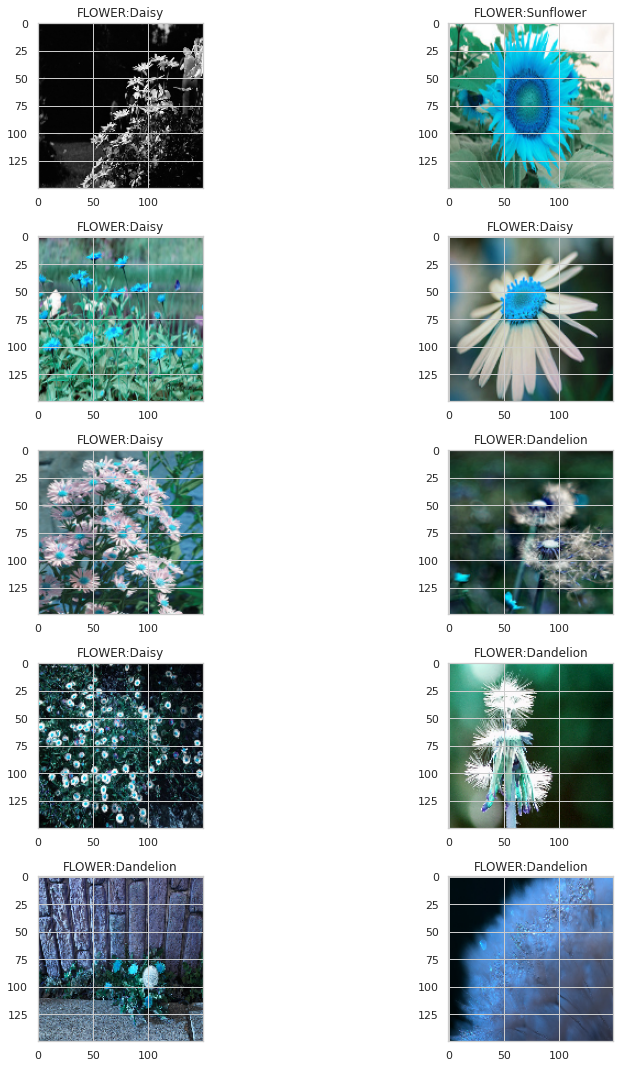

In [10]:
fig,ax = plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('FLOWER:'+Z[l])
plt.tight_layout()

##2.3) Label Encoding the Y array(i.e Daisy->0,Rose->1 etc...)& then One Hot Encoding

In [11]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/255

In [12]:
X.shape

(3333, 150, 150, 3)

In [13]:
Y.shape

(3333, 5)

##2.4) Splitting into Training and Validation Sets

In [14]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

##2.5) Setting the Random Seeds

In [15]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

#3) Modeling

##3.1) Building the ConvNet Model

In [16]:
##Modelling starts using a CNN

model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=96,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=96,kernel_size=(3,3),padding='Same',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

##3.2) Using a LR Annealer

In [17]:
batch_size = 128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)

##3.3) Data Augmentation to prevent Overfitting

In [18]:
datagen = ImageDataGenerator(
    featurewise_center=False, #set input mean to 0 over the dataset
    samplewise_center=False, #set each sample mean to 0
    featurewise_std_normalization=False, #divide inputs by std of the dataset
    samplewise_std_normalization=False, #divide each input by its std
    zca_whitening=False, #apply ZCA whitening
    rotation_range=10, #randomly rotate images in the range(degrees,0 to 180)
    zoom_range=0.1, #Randomly zoom image
    width_shift_range=0.2, #randomly shift images horizontally(fraction of total width)
    height_shift_range=0.2, #randomly shift images vertically(fraction of total height)
    horizontal_flip=True, #randomly flip images
    vertical_flip=False) #randomly flip images

datagen.fit(x_train)

##3.4) Compiling the Keras Model & Summary

In [19]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

##3.5) Fitting on the Training set and making predictions on the Validation set

In [21]:
x_train.shape[0]

2499

In [22]:
batch_size

128

In [23]:
x_train.shape[0]//batch_size

19

In [24]:
History = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),
                              epochs=50,validation_data=(x_test,y_test),
                              verbose=1,steps_per_epoch=x_train.shape[0]//batch_size)

#model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/50
19/19 [==============================] - 16s 677ms/step - loss: 1.2679 - accuracy: 0.4298 - val_loss: 1.0068 - val_accuracy: 0.5827
Epoch 2/50
19/19 [==============================] - 11s 589ms/step - loss: 0.9738 - accuracy: 0.5997 - val_loss: 0.8813 - val_accuracy: 0.6571
Epoch 3/50
19/19 [==============================] - 11s 590ms/step - loss: 0.8271 - accuracy: 0.6828 - val_loss: 0.8214 - val_accuracy: 0.6811
Epoch 4/50
19/19 [==============================] - 11s 595ms/step - loss: 0.8008 - accuracy: 0.6748 - val_loss: 0.8167 - val_accuracy: 0.6954
Epoch 5/50
19/19 [==============================] - 13s 653ms/step - loss: 0.7611 - accuracy: 0.7023 - val_loss: 0.7757 - val_accuracy: 0.7098
Epoch 6/50
19/19 [==============================] - 12s 606ms/step - loss: 0.7451 - accuracy: 0.7221 - val_loss: 0.7691 - val_accuracy: 0.7206
Epoch 7/50
19/19 [==============================] - 11s 594ms/step - loss: 0.7309 - accuracy: 0.7225 - val_loss: 0.7059 - val_accuracy: 0.7374

##4) Evaluating the Model Performance

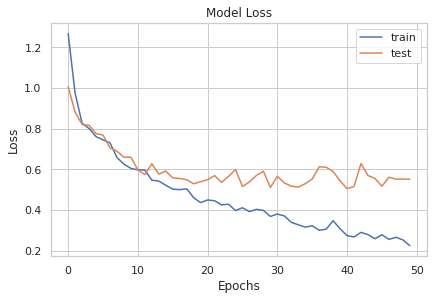

In [25]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','test'])
plt.show()

In [26]:
History.history

{'accuracy': [0.42977645993232727,
  0.5997469425201416,
  0.682834267616272,
  0.6748207211494446,
  0.7023026347160339,
  0.7220581769943237,
  0.7224799394607544,
  0.741459310054779,
  0.7570645213127136,
  0.7692956328392029,
  0.7739350199699402,
  0.7802615165710449,
  0.7832138538360596,
  0.7912273406982422,
  0.8106284141540527,
  0.8135807514190674,
  0.8123154640197754,
  0.817798376083374,
  0.8329818844795227,
  0.8359342217445374,
  0.8317165970802307,
  0.840151846408844,
  0.838886559009552,
  0.841417133808136,
  0.8625052571296692,
  0.8490088582038879,
  0.8595529198646545,
  0.8506959080696106,
  0.8447912335395813,
  0.8667228817939758,
  0.8663011193275452,
  0.8679881691932678,
  0.8768452405929565,
  0.8815789222717285,
  0.8894981145858765,
  0.8797975778579712,
  0.8894981145858765,
  0.8857022523880005,
  0.8705187439918518,
  0.8899198770523071,
  0.8975116014480591,
  0.9072121381759644,
  0.8949810266494751,
  0.8962463140487671,
  0.9046815633773804,
  0

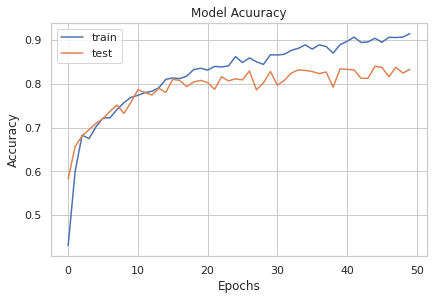

In [27]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Acuuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','test'])
plt.show()

##5) Visualizaing Predictions on the Validation Set

In [28]:
#getting predictions on val set.
pred = model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [29]:
#now storing some properly as well as misclassified indexes
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break
i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

CORRECTLY CLASSIFIED FLOWER IMAGES

In [30]:
prop_class

[0, 1, 2, 3, 4, 5, 6, 7]

In [31]:
prop_class[0]

0

In [32]:
prop_class[1]

1

In [33]:
y_test[prop_class[0]]

array([1., 0., 0., 0., 0.], dtype=float32)

In [34]:
y_test[7]

array([1., 0., 0., 0., 0.], dtype=float32)

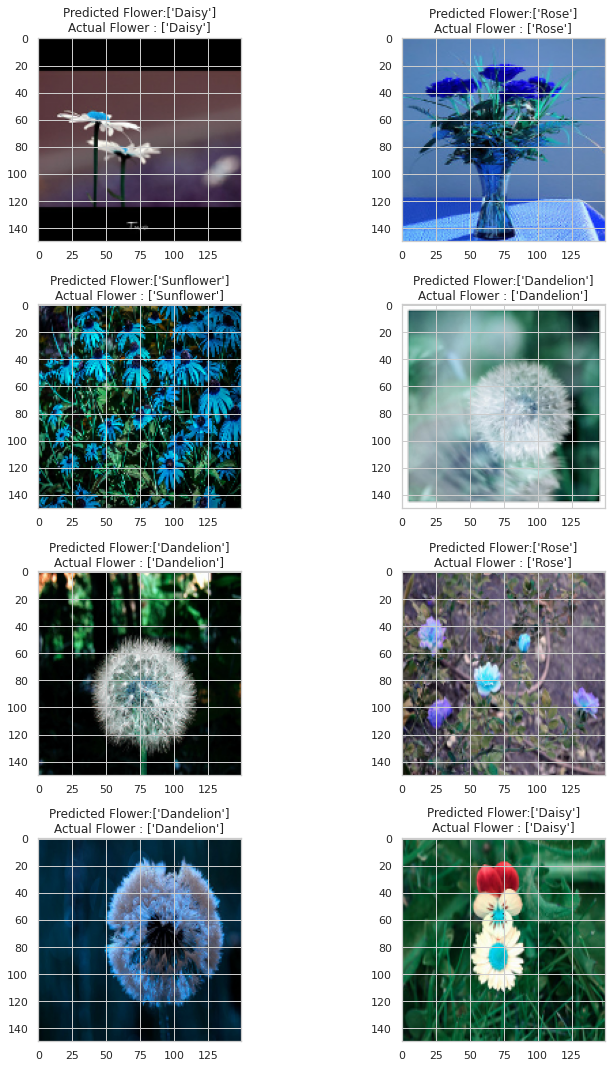

In [35]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax = plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range(2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title('Predicted Flower:'+str(le.inverse_transform([pred_digits[prop_class[count]]]))+'\n'+'Actual Flower : '+
                          str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count +=1

MISSCLASSIFIED IMAGES OF FLOWERS

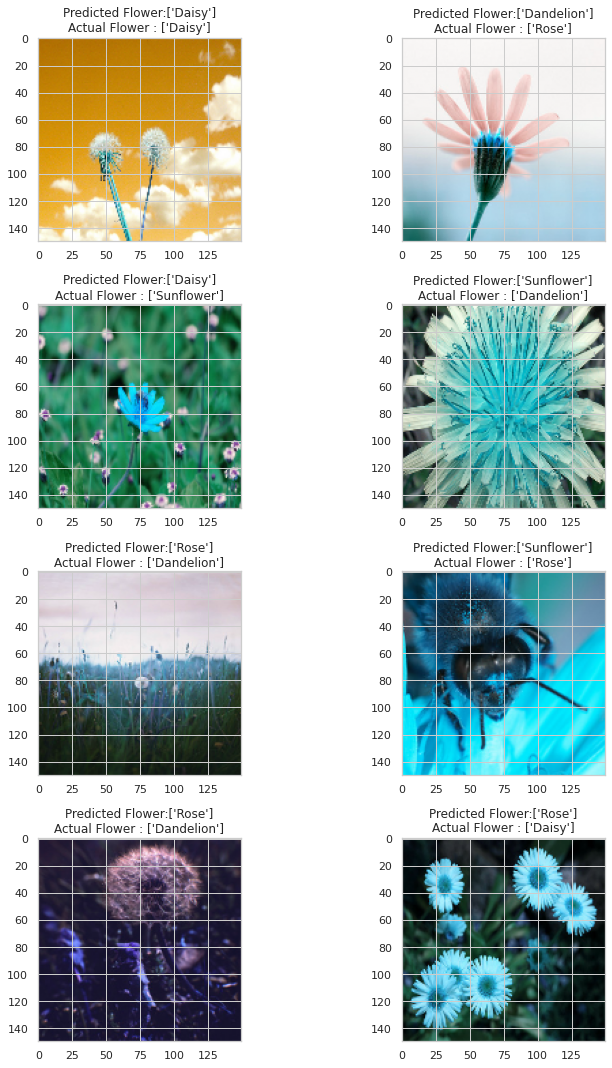

In [36]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax = plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range(2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title('Predicted Flower:'+str(le.inverse_transform([pred_digits[mis_class[count]]]))+'\n'+'Actual Flower : '+
                          str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count +=1